In [1]:
import importlib
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import lib_p3inn as p3inn
from lib_p3inn import shift_to_median, compute_shift_to_median

In [2]:
class Args:
    quantile = 0.9


args = Args()

##########################################################
################## Data Loading Section ##################
##########################################################
data_dir = Path("../data_out/3pinn/All_UQ_Langmuir")
dataLoader = p3inn.CL_dataLoader(original_data_path=data_dir)
X, Y = dataLoader.load()
# mask = X[:,0] >= 1e-2
# print(mask.shape, np.count_nonzero(mask))
# X = X[mask,:].copy()
# Y = Y[mask,:].copy()
if len(Y.shape) == 1:
    Y = Y.reshape(-1, 1)

# The first 550 points should be enough
X = X[:550].copy()
Y = Y[:550].copy()

# Y = 1 / Y
print(X.min())

0.003706145915579495


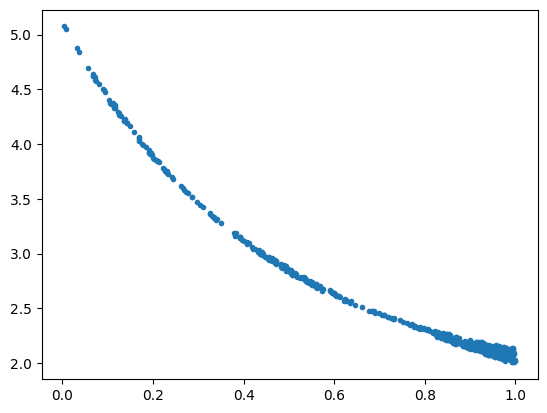

In [3]:
plt.plot(X, Y, ".")
plt.show()

In [4]:
SEED = 1


# random split
xTrainValid, xTest, yTrainValid, yTest = train_test_split(
    X, Y, test_size=0.1, random_state=SEED, shuffle=True
)
## Split the validation data
xTrain, xValid, yTrain, yValid = train_test_split(
    xTrainValid, yTrainValid, test_size=0.1, random_state=SEED, shuffle=True
)

### Data normalization
scalar_x = StandardScaler()
scalar_y = StandardScaler()

xTrain = scalar_x.fit_transform(xTrain)
xValid = scalar_x.fit_transform(xValid)
xTest = scalar_x.transform(xTest)

yTrain = scalar_y.fit_transform(yTrain)
yValid = scalar_y.fit_transform(yValid)
yTest = scalar_y.transform(yTest)

### To tensors
xTrain = torch.Tensor(xTrain)
xValid = torch.Tensor(xValid)
xTest = torch.Tensor(xTest)

yTrain = torch.Tensor(yTrain)
yValid = torch.Tensor(yValid)
yTest = torch.Tensor(yTest)

print(xTrain.shape)
print(xValid.shape)
print(xTest.shape)
print(yTrain.shape)
print(yValid.shape)
print(yTest.shape)
# exit()

torch.Size([405, 1])
torch.Size([45, 1])
torch.Size([50, 1])
torch.Size([405, 1])
torch.Size([45, 1])
torch.Size([50, 1])


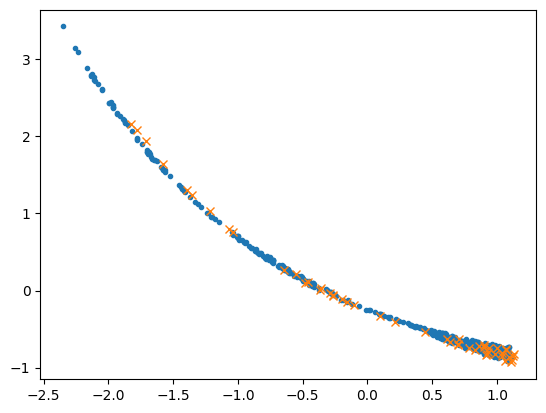

In [5]:
plt.plot(xTrain, yTrain, ".")
plt.plot(xTest, yTest, "x")
# plt.plot(xValid, yValid, "d")
plt.show()

In [6]:
#########################################################
############## End of Data Loading Section ##############
#########################################################

num_inputs = dataLoader.getNumInputsOutputs(xTrain)
num_outputs = dataLoader.getNumInputsOutputs(yTrain)
print(num_inputs, num_outputs)

1 1


In [7]:

configs = {}
### Some other general input info
configs["quantile"] = (
    args.quantile
)  # # target percentile for optimization step# target percentile for optimization step,
# 0.95 by default if not specified

######################################################################################
# TODO: Re-Implement this
# Multiple quantiles, comment out this line in order to run single quantile estimation
# configs['quantile_list'] = np.arange(0.05, 1.00, 0.05) # 0.05-0.95
######################################################################################

### specify hypar-parameters for the training
configs["seed"] = 34875663  # general random seed
configs["num_neurons_mean"] = [64]  # hidden layer(s) for the 'MEAN' network
configs["num_neurons_up"] = [64]  # hidden layer(s) for the 'UP' network
configs["num_neurons_down"] = [64]  # hidden layer(s) for the 'DOWN' network
configs["Max_iter"] = 50000  # 5000,
LR = 1e-2
DECAY_RATE = 0.96  # Define decay rate
DECAY_STEPS = 10000  # Define decay steps
random.seed(configs["seed"])
np.random.seed(configs["seed"])
torch.manual_seed(configs["seed"])

In [8]:
""" Create network instances"""
net_mean = p3inn.UQ_Net_mean(configs, num_inputs, num_outputs)
net_up = p3inn.UQ_Net_std(configs, num_inputs, num_outputs, net="up")
net_down = p3inn.UQ_Net_std(configs, num_inputs, num_outputs, net="down")

# Initialize trainer and conduct training/optimizations
trainer = p3inn.CL_trainer(
    configs,
    net_mean,
    net_up,
    net_down,
    x_train=xTrain,
    y_train=yTrain,
    x_valid=xValid,
    y_valid=yValid,
    x_test=xTest,
    y_test=yTest,
    lr=LR,
    decay_rate=DECAY_RATE,  # Pass decay rate to trainer
    decay_steps=DECAY_STEPS,  # Pass decay steps to trainer
)
trainer.train()  # training for 3 networks
# previous losses without lr decay:
# 0.102, 0.103, 0.077
# with lr decay (DECAY_STEPS=1000):
# 0.107, 0.029, 0.078
# with lr decay (DECAY_STEPS=100):
# tdlr: worse
# with lr decay (DECAY_STEPS=100, LR=1e-1):
# tdlr: worse
# with lr decay (DECAY_STEPS=1000, LR=1e-3, EPOCHS=10000):
# tdlr: worse
# with lr decay (DECAY_STEPS=1000, LR=1e-2, EPOCHS=10000):
# tdlr: worse
# with lr decay (DECAY_STEPS=1000, LR=1e-2, EPOCHS=2*10**5):
# tdlr: not better

# 0.0738, 0.0367, 0.0386
#

Training MEAN Network
Epoch      1, Train Loss: 1.22e+00, Validation Loss: 1.20e+00
Epoch   5000, Train Loss: 7.87e-02, Validation Loss: 8.67e-02
Epoch  10000, Train Loss: 2.92e-02, Validation Loss: 4.64e-02
Epoch  15000, Train Loss: 2.56e-02, Validation Loss: 4.52e-02
Epoch  20000, Train Loss: 2.59e-02, Validation Loss: 4.43e-02
Epoch  25000, Train Loss: 2.55e-02, Validation Loss: 4.48e-02
Epoch  30000, Train Loss: 2.47e-02, Validation Loss: 4.48e-02
Epoch  35000, Train Loss: 2.44e-02, Validation Loss: 4.52e-02
Epoch  40000, Train Loss: 2.45e-02, Validation Loss: 4.51e-02
Epoch  45000, Train Loss: 2.43e-02, Validation Loss: 4.54e-02
Epoch  50000, Train Loss: 2.43e-02, Validation Loss: 4.54e-02
Training UP Network
Epoch      1, Train Loss: 3.01e+00, Validation Loss: 2.70e+00
Epoch   5000, Train Loss: 1.29e-02, Validation Loss: 4.28e-02
Epoch  10000, Train Loss: 1.31e-02, Validation Loss: 4.34e-02
Epoch  15000, Train Loss: 1.27e-02, Validation Loss: 4.33e-02
Epoch  20000, Train Loss: 1.

In [9]:
c_up, c_down = p3inn.compute_boundary_factors(
    y_train=yTrain.numpy(),
    network_preds=trainer.eval_networks(xTrain, as_numpy=True),
    quantile=configs["quantile"],
    verbose=1,
)

assert c_up > 0 and c_down > 0

--- Start boundary optimizations for SINGLE quantile: 0.9
--- Number of outlier based on the defined quantile: 20
--- c_up: 1.9192695617675781
--- c_down: 2.9087066650390625


In [10]:
pred_train = trainer.eval_networks(xTrain)
pred_valid = trainer.eval_networks(xValid)
pred_test = trainer.eval_networks(xTest)

In [11]:
importlib.reload(p3inn)

PICP_train, MPIW_train = p3inn.caps_calculation(pred_train, c_up, c_down, yTrain.numpy())
PICP_valid, MPIW_valid = p3inn.caps_calculation(pred_valid, c_up, c_down, yValid.numpy())
PICP_test, MPIW_test = p3inn.caps_calculation(pred_test, c_up, c_down, yTest.numpy())

print(PICP_train, MPIW_train)
print(PICP_valid, MPIW_valid)
print(PICP_test, MPIW_test)

0.9012345679012346 0.1103456
0.6888888888888889 0.11767475
0.7 0.12788066


In [13]:
full_preds = trainer.eval_networks(
    torch.from_numpy(scalar_x.transform(X)).to(torch.float32)
)
y_mean_full = scalar_y.inverse_transform(full_preds["mean"])
y_median_full = shift_to_median(y_mean_full, Y)

median_shift = compute_shift_to_median(y_mean_full, Y)

print(median_shift)
print((y_median_full - Y > 0).sum())
print((y_median_full - Y < 0).sum())

-0.007389172026396329
250
250


In [14]:
x_curve = torch.linspace(X.min(), X.max(), 100, dtype=torch.float32).reshape(-1, 1)
x_curve = torch.from_numpy(scalar_x.transform(x_curve)).to(torch.float32)
pred_curves = trainer.eval_networks(x_curve)
pred_curves["median"] = pred_curves["mean"] + median_shift
x_curve = x_curve.detach().numpy()
y_U_PI_array_train = (pred_curves["median"] + c_up * pred_curves["up"]).numpy()
y_L_PI_array_train = (pred_curves["median"] - c_down * pred_curves["down"]).numpy()
y_mean = pred_curves["mean"].numpy()
y_median = pred_curves["median"].numpy()

In [15]:
assert torch.all(pred_curves["up"] > 0)
assert torch.all(pred_curves["down"] > 0)

# since c > 0 and std network prediction > 0, the median should always be between the upper and lower prediction intervals and not cross them
assert np.all(y_median > y_L_PI_array_train)
assert np.all(y_median < y_U_PI_array_train)

In [16]:
x_curve = scalar_x.inverse_transform(x_curve)
y_mean = scalar_y.inverse_transform(y_mean)
y_median = scalar_y.inverse_transform(y_median)
y_U_PI_array_train = scalar_y.inverse_transform(y_U_PI_array_train)
y_L_PI_array_train = scalar_y.inverse_transform(y_L_PI_array_train)

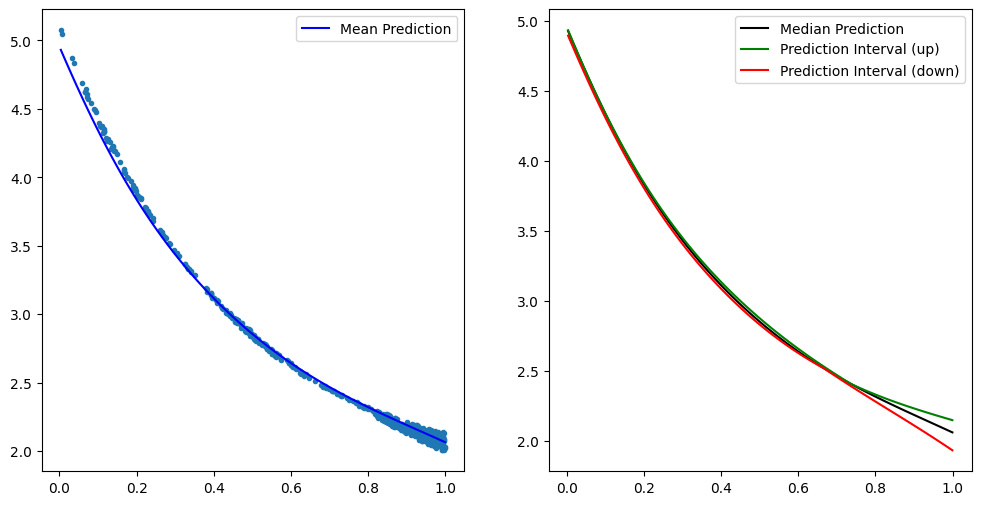

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Scatter plot of the original data points
ax1.plot(X, Y, ".")
ax1.plot(x_curve, y_mean, "b-", label="Mean Prediction")

# Plot the mean curve
# ax2.plot(x_curve, y_mean, "b-", label="Mean Prediction")
ax2.plot(x_curve, y_median, "k-", label="Median Prediction")

# Fill the area between the upper and lower prediction intervals with transparency
# ax2.fill_between(x_curve.flatten(), y_L_PI_array_train.flatten(), y_U_PI_array_train.flatten(), color='green', alpha=0.3, label="Prediction Interval")
ax2.plot(
    x_curve.flatten(),
    y_U_PI_array_train.flatten(),
    "g-",
    label="Prediction Interval (up)",
)
ax2.plot(
    x_curve.flatten(),
    y_L_PI_array_train.flatten(),
    "r-",
    label="Prediction Interval (down)",
)

ax1.legend()
ax2.legend()
plt.show()

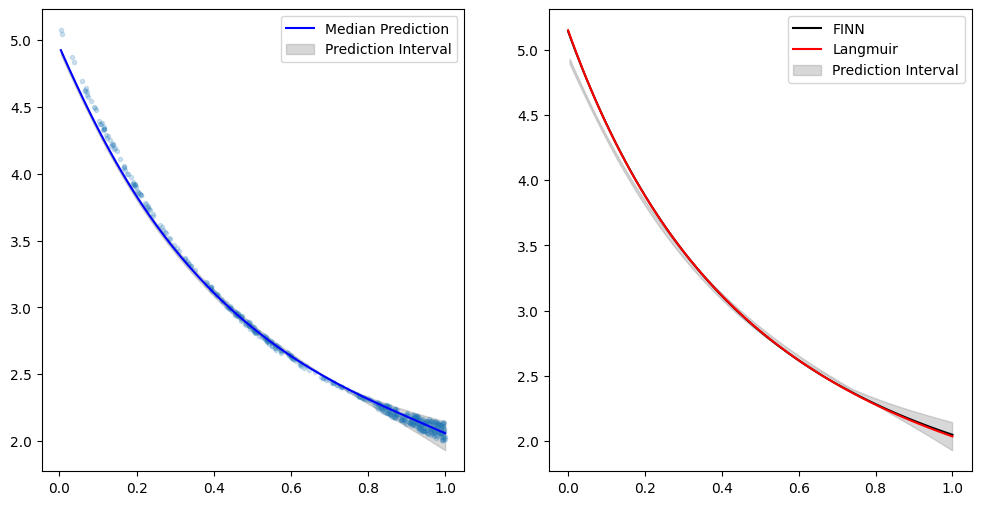

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Scatter plot of the original data points
ax1.plot(X, Y, ".", alpha=0.2)

# Plot the mean curve
# ax1.plot(x_curve, y_mean, "b-", label="Mean Prediction")
ax1.plot(x_curve, y_median, "b-", label="Median Prediction")

# Plot additional curves
analytical_retardation_type = "langmuir"
u_finn_ret = np.load(
    f"../data_out/{analytical_retardation_type}/default_finn/u_ret.npy"
)
finn_ret = np.load(
    f"../data_out/{analytical_retardation_type}/default_finn/predicted_retardations/retPred_100.npy"
)
ax2.plot(u_finn_ret, finn_ret, "k-", label="FINN")
ax2.plot(
    u_finn_ret,
    np.load(
        f"../data_out/{analytical_retardation_type}/default_finn/retardation_{analytical_retardation_type}.npy"
    ),
    "r-",
    label=analytical_retardation_type.capitalize(),
)

# Fill the area between the upper and lower prediction intervals with transparency
ax1.fill_between(
    x_curve.flatten(),
    y_L_PI_array_train.flatten(),
    y_U_PI_array_train.flatten(),
    color="grey",
    alpha=0.3,
    label="Prediction Interval",
)
ax2.fill_between(
    x_curve.flatten(),
    y_L_PI_array_train.flatten(),
    y_U_PI_array_train.flatten(),
    color="grey",
    alpha=0.3,
    label="Prediction Interval",
)

ax1.legend()
ax2.legend()
plt.show()

# Up-Down Training Data

In [19]:
data_train_up, data_train_down = p3inn.create_PI_training_data(
    trainer.networks["mean"], X=trainer.x_train, Y=trainer.y_train
)
data_val_up, data_val_down = p3inn.create_PI_training_data(
    trainer.networks["mean"], X=trainer.x_valid, Y=trainer.y_valid
)

In [20]:
type(xTrain)

torch.Tensor

In [21]:
from pathlib import Path

pup = Path("../data_out/tmp/3pinn_res_up.npy")
pdown = Path("../data_out/tmp/3pinn_res_down.npy")
pup.parent.mkdir(exist_ok=True, parents=True)
pdown.parent.mkdir(exist_ok=True, parents=True)
np.save(pup, data_train_up)
np.save(pdown, data_train_up)

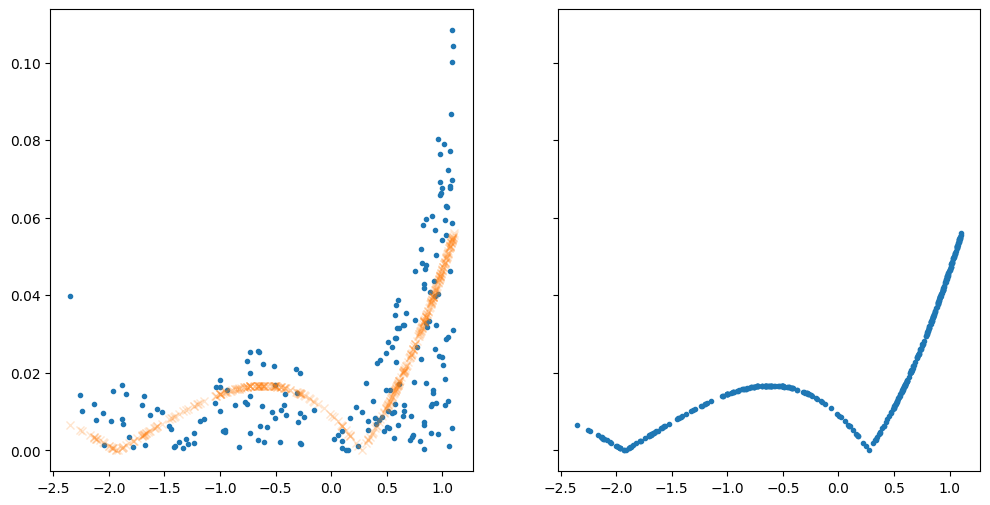

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
ax1.plot(*data_train_up, ".")
ax1.plot(
    xTrain.detach().numpy(),
    trainer.networks["up"](xTrain).detach().numpy(),
    "x",
    alpha=0.2,
)
ax2.plot(xTrain.detach().numpy(), trainer.networks["up"](xTrain).detach().numpy(), ".")
# plt.plot(*data_train_down, "x")
plt.show()

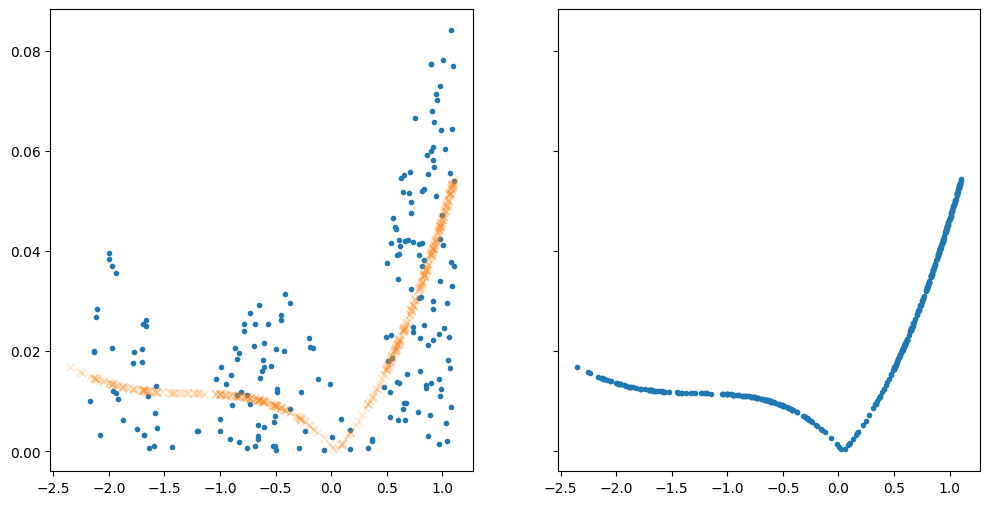

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
ax1.plot(*data_train_down, ".")
ax1.plot(
    xTrain.detach().numpy(),
    trainer.networks["down"](xTrain).detach().numpy(),
    "x",
    alpha=0.2,
)
ax2.plot(
    xTrain.detach().numpy(), trainer.networks["down"](xTrain).detach().numpy(), "."
)
# plt.plot(*data_train_down, "x")
plt.show()